# Fake vs. Real News
December 28, 2020

Project goal: Implement a text mining algorithm to accurately classify data based on whether it is fake news or real news. I begin with an EDA and compare two methods in this modeling process: k-means and SVM (support vector machine). Given the incredible accuracy of the SVM, I recommend using an SVM to classify this text data. 

## Read in data & import libraries

In [1]:
import nltk, string
import re
import numpy as np
import pandas as pd
import gensim
from collections import Counter #for stopword function
from sklearn.feature_extraction.text import CountVectorizer #for stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt #for elbow method & visualization
from sklearn.datasets.samples_generator import make_blobs #for elbow method
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/ellie/Documents/anacondanavigator/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [45]:
########################################## OPTIONAL ##########################################
#pd.set_option('display.max_colwidth', None) #this should allow us to see an entire cell (MAKES OUTPUT QUITE LONG)

In [2]:
fake = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/Fake.csv") #reading in the fake news data
true = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/True.csv") #reading in the real news data

## Merging the datasets 

In [3]:
#Creating identifier column for whether the observation is from fake or true news
fake["source"] = 1
true["source"] = 0
dataframes = [fake, true]
merged = pd.concat(dataframes) #merging the dataframes together
merged.tail() #Looking at the last 5 rows of the merged dataset

,title,text,subject,date,source
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


In [4]:
merged.text[np.random.randint(1,23000)] #taking a look at one cell of text

6918    Political contributor and conservative editor ...
6918    SHANGHAI (Reuters) - Chinese state media on Mo...
Name: text, dtype: object

In [5]:
merged.isna().any().sum() #checking for any null values

0

In [6]:
#Looking at the unique subject values & their respective countts
print(merged['subject'].value_counts())
print("*****************************")
print(merged['source'].value_counts()) #Looking at how many fake vs. real news observations we have
print("*****************************")

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64
*****************************
1    23481
0    21417
Name: source, dtype: int64
*****************************


In [7]:
print(merged.groupby(['subject', 'source']).size()) #interesting - only politicsNews & worldnews published real news

subject          source
Government News  1          1570
Middle-east      1           778
News             1          9050
US_News          1           783
left-news        1          4459
politics         1          6841
politicsNews     0         11272
worldnews        0         10145
dtype: int64


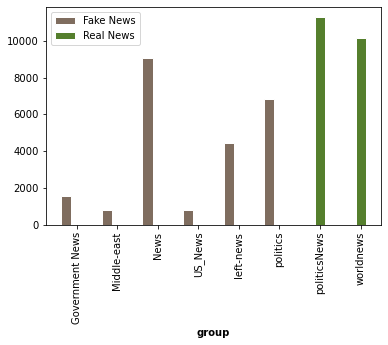

In [8]:
#Visualizing subject by source
from matplotlib import *

#setting width of the bars
barWidth = 0.25

#setting the height of the bars
bars1 = [1570, 778, 9050, 783, 4459, 6841, 0, 0] #Fake news sources
bars2 = [0, 0, 0, 0, 0, 0, 11272, 10145] #Real news sources

#setting the positions of the bars on the x-axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

#making the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Fake News')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Real News')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Government News', 'Middle-east', 'News', 'US_News', 'left-news', 'politics', 'politicsNews', 'worldnews'], rotation = 'vertical')
 
# Create legend & Show graphic
plt.legend()
plt.show()


## Splitting into Training, Test, and Validation

In [9]:
#setting the seed allows for reproducible results
np.random.seed(100)
#split data into train, test, & validation
train, validate, test = np.split(merged.sample(frac = 1), [int(0.7*len(merged)), int(0.9*len(merged))])

## Remove special characters & make text uniform

In [10]:
stop_words = nltk.corpus.stopwords.words('english') #stop words do not provide any meaning to the document (e.g. "it")
train["text"] = train["text"].str.lower() #making words lower case

In [11]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(train['text']))

In [12]:
stop_words = stop_words + ['quite',
  'features',
  'plenty',
  'it',
  'either',
  'said',
  'thing',   
  'Thing',
  'things',
  'Things',                         
  'one',                         
  'hitting',
  'hold',
  'least', 
  'shows',   
  'offers', 
  'well', 
  'next',   
  'like', 
  'theres', 
  'little', 
  'also', 
  'made',  
  'big', 
  'one', 
  'slightly',  
  'finishes', 
  'hints',
  'hint', 
  'note', 
  'nice', 
  'give',   
  'almost',  
  'tight', 
  'potential', 
  'weight', 
  'needs', 
  'pair', 
  'new', 
  'young', 
  'showing', 
  'packed', 
  'along', 
  'time', 
  'layers', 
  'simple', 
  'opens', 
  'yet', 
  'feel',
]

cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus) #K-means requires a matrix as input, so we create cv_matrix here

## Clustering Using K-Means 

In [15]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [16]:
#Appending column with cluster label to dataframe
train['kmeans_cluster'] = km.labels_
train.head()

,title,text,subject,date,source,kmeans_cluster
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0


In [17]:
train1 = pd.DataFrame(train)

#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster"], True, False)
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False


In [18]:
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218


In [13]:
'''
Accuracy: 

Trues: 14412
Falses: 17016

14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%

'''

'\nAccuracy: \n\nTrues: 14412\nFalses: 17016\n\n14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%\n\n'

## TF - IDF 

In [14]:
'''Dr. Healey: Intuitively, TF-IDF implies the following: In any document Dj, if a term occurs frequently, 
it's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, 
it's an important term for distinguishing Dj from other documents. If two documents share terms with 
high term frequency and low document frequency, they are assumed to be similar.'''

#We can't use the elbow method on text data, so will do TF - IDF and then use elbow method

"Intuitively, TF-IDF implies the following. In any document Dj, if a term it occurs frequently, \nit's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, \nit's an important term for distinguishing Dj from other documents. If two documents share terms with \nhigh term frequency and low document frequency, they are assumed to be similar."

In [15]:
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False


In [20]:
train1.text[np.random.randint(1,23000)]

9664    (reuters) - the michigan house of representati...
9664    the left is going ballistic over supposed word...
Name: text, dtype: object

In [21]:
train1["text"].str.split() # has to be str.split, not .split
train_text = train1['text'].tolist()
train_text = [d.split() for d in train_text]

In [22]:
#  Convert term vectors into gensim dictionary
dict = gensim.corpora.Dictionary( train_text )

corp = [ ]
for i in range( 0, len( train_text ) ):
    corp.append( dict.doc2bow( train_text[ i ] ) )

In [23]:
#  Create TF - IDF vectors based on term vectors bag-of-word corpora

tfidf_model = gensim.models.TfidfModel( corp )

tfidf = [ ]
for i in range( 0, len( corp ) ):
    tfidf.append( tfidf_model[ corp[ i ] ] )

#  Create pairwise document similarity index

n = len( dict )
index = gensim.similarities.SparseMatrixSimilarity( tfidf_model[ corp ], num_features = n )

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import os, sys, email,re
%matplotlib inline
plt.style.use('fivethirtyeight')

In [25]:
data = train1['text']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 100)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

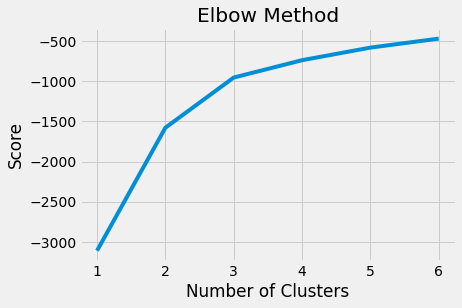

In [26]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Evaluating K-Means Now 

In [27]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [28]:
#Appending column with cluster label to dataframe
train1['kmeans_cluster_testing'] = km.labels_
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy,kmeans_cluster_testing
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False,0
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True,0
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True,0
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True,0
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False,0


In [29]:
#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster_testing"], True, False)
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster,kmeans_cluster_testing
,count,count,count,count,count,count,count
accuracy,,,,,,,
False,15210,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218,16218


In [ ]:
'''
Accuracy: 

Looks like 2 is the optimal number of clusters, as it provides highest accuracy
'''

## Evaluating Performance on Validation Data 

In [30]:
#Normalizing the data first
validate["text"] = validate["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(validate['text']))

In [31]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [32]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [33]:
#Appending column with cluster label to dataframe
validate['kmeans_cluster'] = km.labels_
validate.head()

,title,text,subject,date,source,kmeans_cluster
767,New York Mayor de Blasio wins re-election in w...,new york (reuters) - democratic new york city ...,politicsNews,"November 7, 2017",0,0
19737,U.S. lawmaker wants North Korea out of the U.N.,washington (reuters) - the chairman of the u.s...,worldnews,"September 18, 2017",0,0
16120,CUBANS BRUTALLY ATTACK Brave Man Waving US Fla...,this is what having no freedom of speech looks...,Government News,"May 2, 2017",1,0
15604,MISS ME YET? CNN Poll Shows America Had A Diff...,"unfortunately, our troops have been affected m...",politics,"Jun 3, 2015",1,0
5020,WATCH: A Nazi Apologist Has Created A Group F...,jayme liardi makes no secret of the fact that ...,News,"August 16, 2016",1,1


In [34]:
validate1 = pd.DataFrame(validate)

#Identifying accuracy of clusters
validate1["accuracy"] = np.where(validate1["source"] == validate1["kmeans_cluster"], True, False)
validate1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
767,New York Mayor de Blasio wins re-election in w...,new york (reuters) - democratic new york city ...,politicsNews,"November 7, 2017",0,0,True
19737,U.S. lawmaker wants North Korea out of the U.N.,washington (reuters) - the chairman of the u.s...,worldnews,"September 18, 2017",0,0,True
16120,CUBANS BRUTALLY ATTACK Brave Man Waving US Fla...,this is what having no freedom of speech looks...,Government News,"May 2, 2017",1,0,False
15604,MISS ME YET? CNN Poll Shows America Had A Diff...,"unfortunately, our troops have been affected m...",politics,"Jun 3, 2015",1,0,False
5020,WATCH: A Nazi Apologist Has Created A Group F...,jayme liardi makes no secret of the fact that ...,News,"August 16, 2016",1,1,True


In [75]:
validate1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,4288,4288,4288,4288,4288,4288
True,4692,4692,4692,4692,4692,4692


In [ ]:
'''
Accuracy on validation data: 46%
'''

## Evaluating Performance on Test Data 

In [35]:
#Normalizing the data first
test["text"] = test["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(test['text']))

In [36]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [37]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [38]:
#Appending column with cluster label to dataframe
test['kmeans_cluster'] = km.labels_
test.head()

,title,text,subject,date,source,kmeans_cluster
6833,Temporary U.S. government funding bill hits sn...,washington (reuters) - the u.s. house of repre...,politicsNews,"December 8, 2016",0,1
3977,JUST IN: Republicans In Florida Are Giving On...,what many people have been predicting througho...,News,"November 1, 2016",1,1
15291,Tillerson says no decision yet on Trump-Putin ...,beijing (reuters) - u.s. secretary of state re...,worldnews,"November 9, 2017",0,1
21929,CLOAKED IN CONSPIRACY: Overview of JFK Files R...,shawn helton 21st century wiresince late octob...,US_News,"December 14, 2017",1,0
21559,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,being called out for his utter incompetence as...,left-news,"Jul 15, 2015",1,1


In [39]:
test1 = pd.DataFrame(test)

#Identifying accuracy of clusters
test1["accuracy"] = np.where(test1["source"] == test1["kmeans_cluster"], True, False)
test1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
6833,Temporary U.S. government funding bill hits sn...,washington (reuters) - the u.s. house of repre...,politicsNews,"December 8, 2016",0,1,False
3977,JUST IN: Republicans In Florida Are Giving On...,what many people have been predicting througho...,News,"November 1, 2016",1,1,True
15291,Tillerson says no decision yet on Trump-Putin ...,beijing (reuters) - u.s. secretary of state re...,worldnews,"November 9, 2017",0,1,False
21929,CLOAKED IN CONSPIRACY: Overview of JFK Files R...,shawn helton 21st century wiresince late octob...,US_News,"December 14, 2017",1,0,False
21559,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,being called out for his utter incompetence as...,left-news,"Jul 15, 2015",1,1,True


In [83]:
test1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,2299,2299,2299,2299,2299,2299
True,2191,2191,2191,2191,2191,2191


In [ ]:
'''
Accuracy on test data: 47%
'''

## Just for fun: Word Cloud for each Cluster & for Real and Fake News

In [40]:
#To get wordcloud to import properly, had to do the following:
import sys
print(sys.executable)

'''
Then in the terminal, copy output from the print command above (line 3) and run this: 
path/to/python -m pip install some_package
'''

/Users/ellie/Documents/anacondanavigator/anaconda3/bin/python


'\nThen in the terminal, copy output from the print command above (line 3) and run this: \npath/to/python -m pip install some_package\n'

In [41]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 

In [42]:
cluster1 = train1.loc[(train1['kmeans_cluster'] == 1)]
cluster2 = train1.loc[(train1['kmeans_cluster'] == 0)]

fake_news = train1.loc[(train1['source'] == 1)]
real_news = train1.loc[(train1['source'] == 0)]

In [43]:
for val in cluster1.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

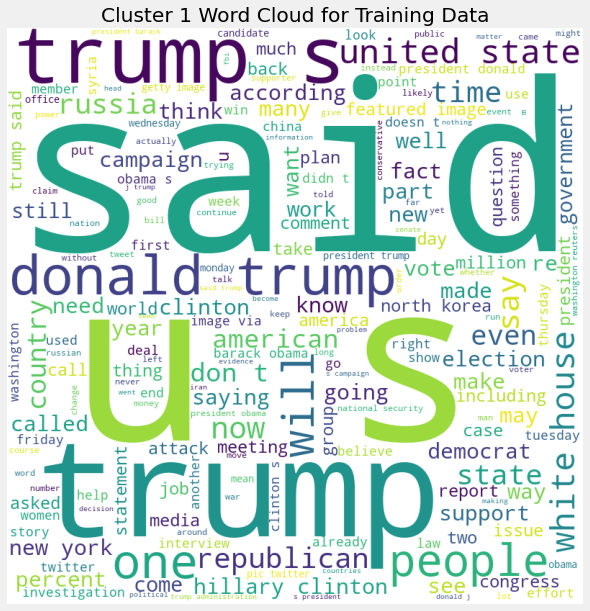

In [44]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 1 Word Cloud for Training Data")
  
plt.show() 

In [45]:
for val in cluster2.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

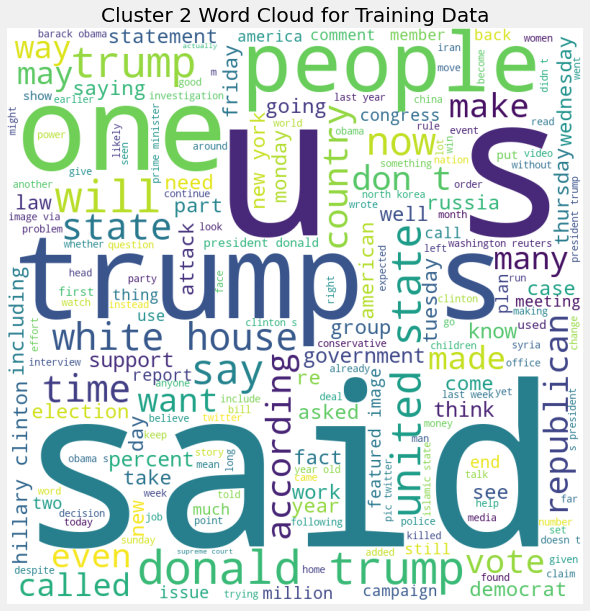

In [46]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 2 Word Cloud for Training Data")
  
plt.show() 

In [47]:
for val in fake_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

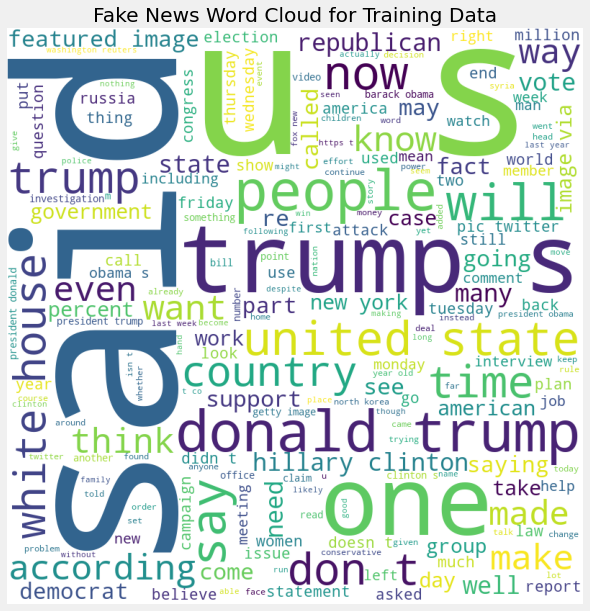

In [48]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Fake News Word Cloud for Training Data")
  
plt.show() 

In [49]:
for val in real_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

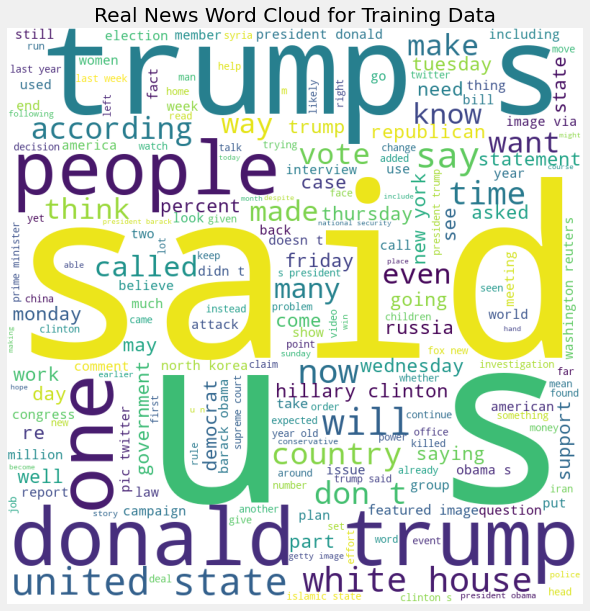

In [50]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Real News Word Cloud for Training Data")
  
plt.show() 

## Now comparing to SVC from Kaggle User

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [52]:
X=merged["text"] #feature / independent variable
y=merged["source"] # target / dependent variable

#Splitting into training & test data to evaluate accuracy & generalizability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
#Fitting the SVC using TF-IDF
clf_text=Pipeline([("tfidf",TfidfVectorizer()),("clf",LinearSVC())])
clf_text.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [54]:
predictions=clf_text.predict(X_test) #Predicting on the test dataset to evaluate accuracy & generalizability

In [55]:
#Much more accurate than k-means
print(metrics.accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test,predictions))

0.994060876020787
0.9943408360128618
